[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Decision Tree Accuracy: 0.6003528892809881
K-Nearest Neighbors Accuracy: 0.6149095721217468
Neural Network Accuracy: 0.6462284958094398
Maximum iterations reached and the optimization hasn't converged yet.


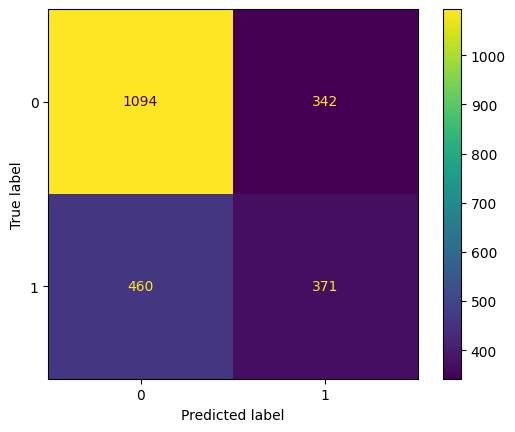

Classification Report:
                      precision    recall  f1-score   support

Funding Unsuccessful       0.70      0.76      0.73      1436
  Funding Successful       0.52      0.45      0.48       831

            accuracy                           0.65      2267
           macro avg       0.61      0.60      0.61      2267
        weighted avg       0.64      0.65      0.64      2267



In [ ]:
import csv, requests, nltk, matplotlib.pyplot as plt, sklearn.tree, sklearn.neighbors, sklearn.neural_network, sklearn.metrics, sklearn.model_selection, sklearn.feature_extraction.text, joblib, warnings
from nltk.corpus import stopwords
nltk.download('stopwords')

warnings.filterwarnings("ignore")

response = requests.get("https://dgoldberg.sdsu.edu/515/kickstarter_data_full.csv")

if response:
    try:
        with open("kickstarter_data_full.csv", "wb") as csv_file:
            csv_file.write(response.content)
    except Exception as e:
        print(f"Error: {e}")
        exit()

    with open("kickstarter_data_full.csv", "r", encoding="latin-1") as file:
        csv_read = csv.DictReader(file)
        data = list(csv_read)

    x = [row['Description'] for row in data]
    y = [1 if row['Status'] == 'Funding Successful' else 0 for row in data]

    # split into training and testing
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.2)

    # vectorize data
    vectorizer = sklearn.feature_extraction.text.CountVectorizer(max_features = 1000, stop_words = stopwords.words("english"))
    x_train_vectorize = vectorizer.fit_transform(x_train)
    x_test_vectorize = vectorizer.transform(x_test)

    # train dt model
    clf_dt = sklearn.tree.DecisionTreeClassifier()
    clf_dt.fit(x_train_vectorize, y_train)

    # train knn model
    clf_knn = sklearn.neighbors.KNeighborsClassifier(7)
    clf_knn.fit(x_train_vectorize, y_train)

    # train nn model
    clf_nn = sklearn.neural_network.MLPClassifier()
    clf_nn.fit(x_train_vectorize, y_train)

    # evaluate all models
    accuracy_dt = sklearn.metrics.accuracy_score(y_test, clf_dt.predict(x_test_vectorize))
    accuracy_knn = sklearn.metrics.accuracy_score(y_test, clf_knn.predict(x_test_vectorize))
    accuracy_nn = sklearn.metrics.accuracy_score(y_test, clf_nn.predict(x_test_vectorize))

    # print accuracy values
    print("Decision Tree Accuracy:", accuracy_dt)
    print("K-Nearest Neighbors Accuracy:", accuracy_knn)
    print("Neural Network Accuracy:", accuracy_nn)

    # save most accurate model to file
    most_accurate_model = max([(accuracy_dt, clf_dt), (accuracy_knn, clf_knn), (accuracy_nn, clf_nn)], key=lambda x: x[0])
    joblib.dump(most_accurate_model[1], "most_accurate_model.joblib")

    # if most accurate model is nn, print a warning
    if most_accurate_model[1] == clf_nn:
        print("Maximum iterations reached and the optimization hasn't converged yet.")

    # load model from file
    clf = joblib.load("most_accurate_model.joblib")

    # print confusion matrix for most accurate model
    cm = sklearn.metrics.confusion_matrix(y_test, clf.predict(x_test_vectorize))
    disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

    # print classification report for most accurate model
    report = sklearn.metrics.classification_report(y_test, clf.predict(x_test_vectorize), target_names=["Funding Unsuccessful", "Funding Successful"])
    print("Classification Report:")
    print(report)

else:
    print("Error: Unable to fetch data from the provided URL.")